# kNN & Clustering

__Суммарное количество баллов: 10__

## kNN и рак (3 балла)

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме

In [329]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd

### Данные


Реализуйте метод `read_cancer_dataset` . Он принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [330]:
CANCER_DATA_PATH = '/Users/vasilijdronov/Machine learning/cancer.csv'

In [331]:
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    col = df.columns
    X = df[col[1:]]
    df
    y = df['label']
    return X, y

In [332]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_cancer


,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [333]:
print(y_cancer)
y_cancer.loc[y_cancer == 'B'] = 0
y_cancer.loc[y_cancer == 'M'] = 1
y_cancer

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: label, Length: 569, dtype: object


0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: label, Length: 569, dtype: object

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.7`.

In [334]:
def train_test_split(X, y, ratio = 0.7):
    l = X_cancer.shape[0]
    X_train = X[: round(l * ratio)]
    y_train = y[: round(l * ratio)]
    X_test = X[round(l * ratio):]
    y_test = y[round(l * ratio):]
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    return X_train, y_train, X_test, y_test

### Метрики

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [335]:
def get_precision_recall_accuracy(y_pred, y_true):
    TP, FP, FN, TN = 0, 0, 0, 0
    for i in range(y_pred.shape[0]):
        if y_pred[i] == y_true.iloc[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true.iloc[i] == 0:
            FP += 1
        if y_pred[i] == 0 and y_true.iloc[i] == 1:
            FN += 1
        if y_pred[i] == y_true.iloc[i] == 1:
            TP += 1
    precision = []
    recall = []
    
    precision.append(TP/(TP + FP))
    recall.append(TP/(TP + FN))
    precision.append(TN/(TN + FN))
    recall.append(TN/(TN + FP))
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [336]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [337]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

## KNN
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [338]:
from sklearn.neighbors import KDTree

class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.neighbors = n_neighbors
        self.leaf_size = leaf_size 
    
    def fit(self, X, y):
        self.tree = KDTree(X, self.leaf_size)
        self.y = y
        
        
    def predict_proba(self, X):
        self.df = pd.DataFrame([], columns=['B','M']) 
#        self.i = 0 
        for index, st in X.iterrows():
            st = pd.DataFrame([st])
            _, self.ind = self.tree.query(st, k = self.neighbors) 
            self.M = 0 
            self.B = 0
            for i in self.ind[0]:
                if self.y[i] == 1:
                    self.M += 1
                else:
                    self.B += 1 
            self.df.loc[index] = [self.B/(self.M + self.B), self.M/(self.M + self.B)] # i[0] заменил на index
#           self.i += 1
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        return self.df.values
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на датасете _cancer_

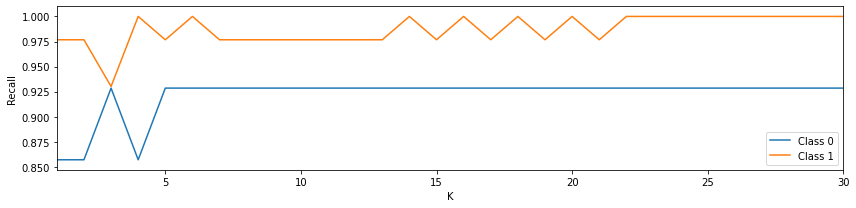

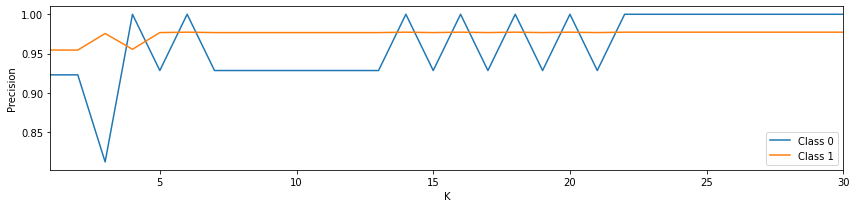

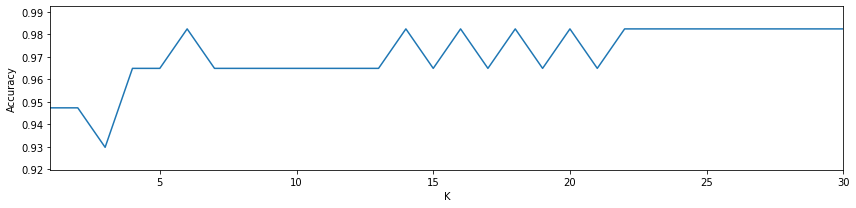

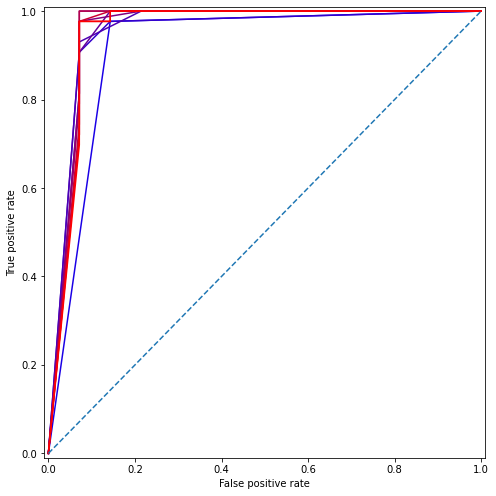

In [339]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)




Проанализируйте полученные графики. Какой параметр `k` кажется лучшим? Какая из метрик лучше всего отражает качество модели? 

Кажется, что лучший k = 6, так как он минимальный элемент, который показывает высокие результаты по всем показателем

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [340]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

In [341]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

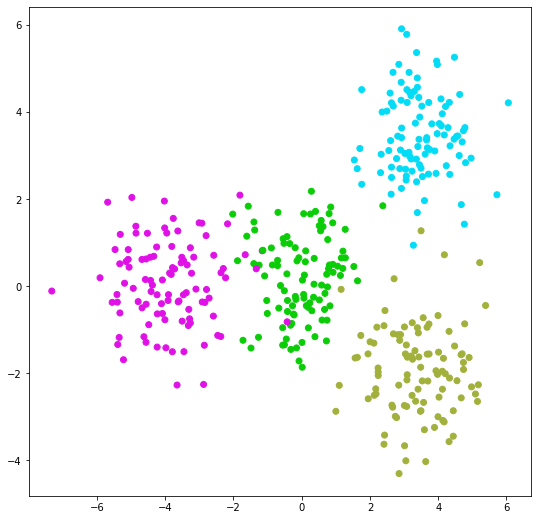

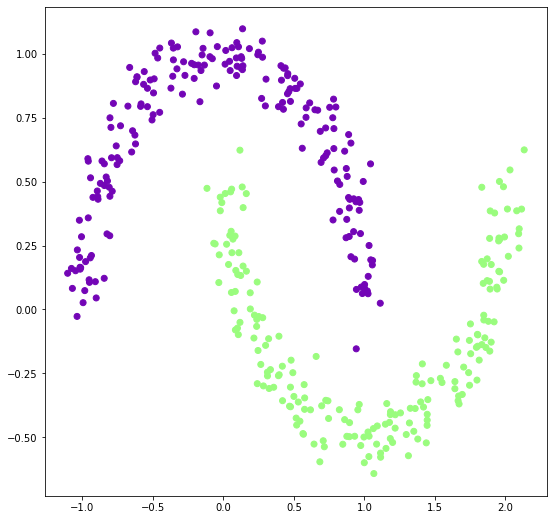

In [342]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### K-means (3 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [343]:
import copy

class kMeans:
    def __init__(self, n_clusters, init="k-means++", max_iter=300):
        self.init = init
        self.n_clusters = n_clusters
        self.clusters = {}
        for i in range(n_clusters):
            self.clusters[i] = []
            
        
    def fit(self, X, y=None):
        if self.init == 'sample':
            X = pd.DataFrame(X)
            self.centroids = []
            self.a = X.sample(n = self.n_clusters)
            for i in range(self.n_clusters):
                self.centroids.append(self.a.iloc[i])
        elif self.init == 'random':
            self.centroids = []
            for i in range(self.n_clusters):
                self.centroids.append(list(12*np.random.random_sample((1, 2)) - 6))
        elif self.init == 'k-means++':
            X = pd.DataFrame(X)
            self.centroids = []
            self.a = X.sample(n = 1)
            self.centroids.append(self.a.iloc[0])
            for i in range(self.n_clusters - 1):
                self.main_dist = []
                for _, data in X.iterrows():
                    self.dist = []
                    for centroid in self.centroids:
                        self.dist.append(np.linalg.norm(centroid- data))
                    self.main_dist.append(min(self.dist)) #min  на max

                self.centroids.append(X.iloc[self.main_dist.index(max(self.main_dist))])    
        return self.centroids
    
    def recalculate_clusters(self, X):
        self.clusters = {}
        self.numbers = []
        for i in range(self.n_clusters):
            self.clusters[i] = []
        for data in X:
            euc_dist = []
            for j in range(self.n_clusters):
                euc_dist.append(np.linalg.norm(data - self.centroids[j]))
            self.clusters[euc_dist.index(min(euc_dist))].append(data)
            self.numbers.append(euc_dist.index(min(euc_dist)))
            
    def recalculate_clusters(self, X):
        self.clusters = {}
        for i in range(self.n_clusters):
            self.clusters[i] = []
        i = 0
        changed = False
        for data in X:
            euc_dist = []
            for j in range(self.n_clusters):
                euc_dist.append(np.linalg.norm(data - self.centroids[j]))
            self.clusters[euc_dist.index(min(euc_dist))].append(data)
            if self.numbers[i] != euc_dist.index(min(euc_dist)):
                self.numbers[i] = euc_dist.index(min(euc_dist))
                changed = True
            i += 1
        return changed
    
    def recalculate_centroids(self):
        for i in range(self.n_clusters):
            self.centroids[i] = np.average(self.clusters[i], axis=0)

            
    
    def predict(self, X):
        self.numbers = []
        self.eps = True
        while self.eps:
            self.numbers = []
            for data in X:
                euc_dist = []
                for j in range(self.n_clusters):
                    self.euc_dist.append(np.linalg.norm(data - self.centroids[j]))
                self.clusters[self.euc_dist.index(min(self.euc_dist))].append(data)
                self.numbers.append(self.euc_dist.index(min(self.euc_dist)))
            self.old_centroids = copy.deepcopy(self.centroids) # сохраняем старые центроиды
            for i in range(self.n_clusters):
                self.centroids[i] = np.average(self.clusters[i], axis = 0)
            self.eps = True
            self.centroids = np.concatenate(self.centroids).reshape(len(self.centroids),len(self.centroids[0]))
            if (self.centroids - self.old_centroids).all() == self.centroids.all():
                self.eps = False

                
        return self.numbers
    
    def predict(self, X):
        self.numbers = []
        for data in X:
            euc_dist = []
            for j in range(self.n_clusters):
                euc_dist.append(np.linalg.norm(data - self.centroids[j]))
            self.clusters[euc_dist.index(min(euc_dist))].append(data)
            self.numbers.append(euc_dist.index(min(euc_dist)))
        for i in range(10):
            self.recalculate_centroids()
            self.recalculate_clusters(X)
        return self.numbers
    
    def predict(self, X):
        self.numbers = []
        for data in X:
            euc_dist = []
            for j in range(self.n_clusters):
                euc_dist.append(np.linalg.norm(data - self.centroids[j]))
            self.clusters[euc_dist.index(min(euc_dist))].append(data)
            self.numbers.append(euc_dist.index(min(euc_dist)))
        self.recalculate_centroids()
        flag = self.recalculate_clusters(X)
        while flag:
            self.recalculate_centroids()
            flag = self.recalculate_clusters(X)
        return self.numbers
            
            

        
        
        
        

In [344]:
#from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=4, random_state=0).fit(X_1)
#labels = kmeans.predict(X_1)
#visualize_clasters(X_1, labels)

#kmeans = KMeans(n_clusters=2, random_state=0).fit(X_2)
#labels = kmeans.predict(X_2)
#visualize_clasters(X_2, labels)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

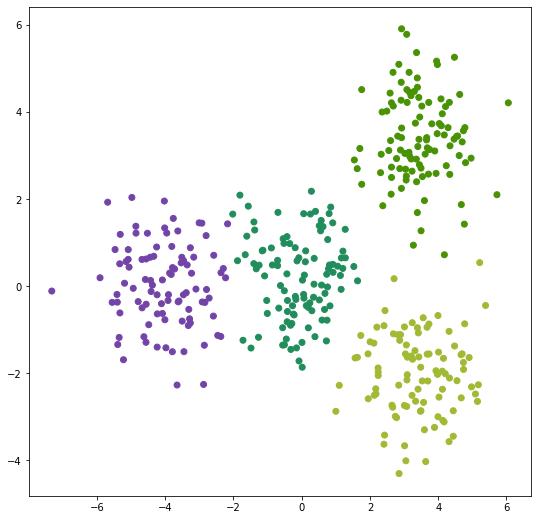

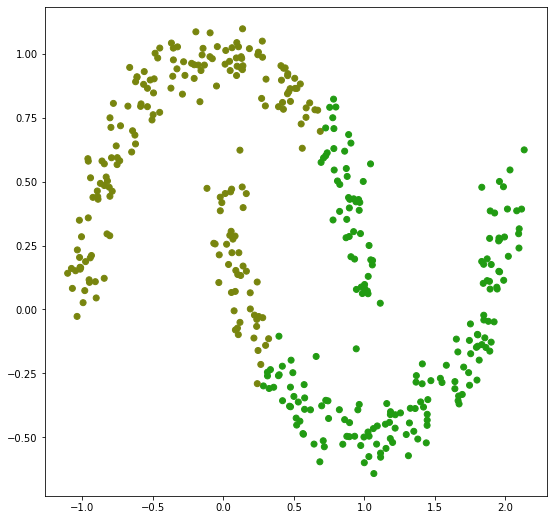

In [345]:
kmeans = kMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = kMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### DBScan (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [346]:
from sklearn.neighbors import KDTree
import numpy

class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.C = 0
        self.eps = eps 
        self.min_samples = min_samples 
        self.leaf_size = leaf_size
#        self.metric = metric
    
    def regionQuery(self, X, P): 
#        neighbors = []
#        for Pn in range(0, len(X)):
#            if numpy.linalg.norm(X[P] - X[Pn]) < self.eps:
#                neighbors.append(Pn)
#        return neighbors
        return self.tree.query_radius(X[P].reshape(1, -1), r=self.eps)
    
    def growCluster(self, X, P):
        self.labels[P] = self.C
        i = 0
        while i < len(self.NeighborPts):
            Pn = self.NeighborPts[i]
            if self.labels[Pn] == -2:
                self.labels[Pn] = self.C
            elif self.labels[Pn] == -1:
                self.labels[Pn] = self.C
                PnNeighborPts = self.regionQuery(X, Pn)[0] #убрал [0]
                if len(PnNeighborPts) >= self.min_samples:
                    self.NeighborPts = np.hstack((self.NeighborPts, PnNeighborPts))
                    self.NeighborPts = np.unique(self.NeighborPts)
            i += 1

        
    def fit_predict(self, X, y=None): # eps MinPts
        self.tree = KDTree(X, self.leaf_size)
        self.labels = [-1]*len(X)
        self.C = -1
        for P in range(0, len(X)):
            if not (self.labels[P] == -1):
                continue
            self.NeighborPts = self.regionQuery(X, P)[0] #убрал [0]
            if len(self.NeighborPts) < self.min_samples:
                self.labels[P] = -2
            else:
                self.C += 1
                self.growCluster(X, P)
        print(self.labels)
        return self.labels
    
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.C = 0
        self.eps = eps 
        self.min_samples = min_samples 
        self.leaf_size = leaf_size
#        self.metric = metric
    
    def regionQuery(self, X, P): 
#        neighbors = []
#        for Pn in range(0, len(X)):
#            if numpy.linalg.norm(X[P] - X[Pn]) < self.eps:
#                neighbors.append(Pn)
#        return neighbors
        return self.tree.query_radius(X[P].reshape(1, -1), r=self.eps)
    
    def growCluster(self, X, P):
        self.labels[P] = self.C
        i = 0
        while i < len(self.NeighborPts):
            Pn = self.NeighborPts[i]
            if self.labels[Pn] == -1:
                self.labels[Pn] = self.C
            elif self.labels[Pn] == 0:
                self.labels[Pn] = self.C
                PnNeighborPts = self.regionQuery(X, Pn)[0] #убрал [0]
                if len(PnNeighborPts) >= self.min_samples:
                    self.NeighborPts = np.hstack((self.NeighborPts, PnNeighborPts))
        #            self.NeighborPts = np.unique(self.NeighborPts)
            i += 1

        
    def fit_predict(self, X, y=None): # eps MinPts
        self.tree = KDTree(X, self.leaf_size)
        self.labels = [0]*len(X)
        self.C = 0
        for P in range(0, len(X)):
            if not (self.labels[P] == 0):
                continue
            self.NeighborPts = self.regionQuery(X, P)[0] #убрал [0]
            if len(self.NeighborPts) < self.min_samples:
                self.labels[P] = -1
            else:
                self.C +=1
                self.growCluster(X, P)
                
        num_u = len(np.unique(self.labels))
        for i in range(len(self.labels)):
            if self.labels[i] == -1:
                self.labels[i] = num_u
            if self.labels[i] == num_u:
                self.labels[i] = 0
            

        return self.labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

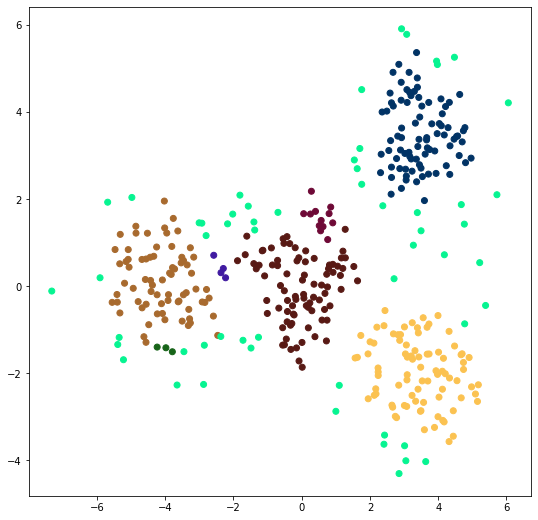

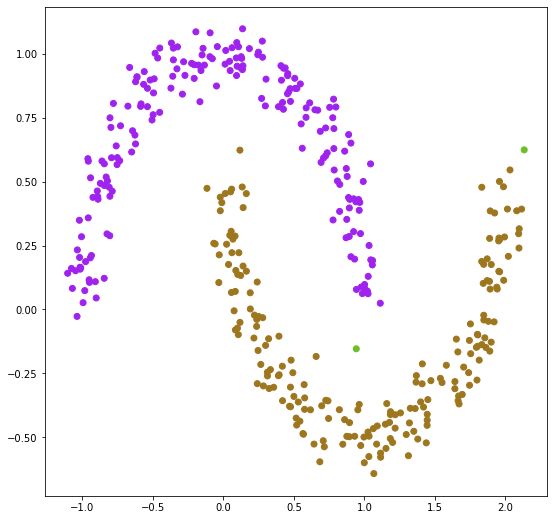

In [357]:
dbscan = DBScan(0.51)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(0.15)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

davies_bouldin_score хороший у X_2 и не такой хороший у X_1
silhouette_score такая же ситуация, в данном случае для X_1 он даже отрицательный, что говорит нам, что минимальная дистанция от точек до другого кластера меньше, чем средняя до своего

In [353]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [356]:
print(davies_bouldin_score(X_1, labels))
print(davies_bouldin_score(X_2, labels))
print(silhouette_score(X_1, labels))
print(silhouette_score(X_2, labels))


22.16516831779082
1.8680078027138307
-0.18114655383457592
0.16521908566863133
